In [ ]:
import re
from collections import Counter
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Read dataset
with open("text8", "r") as f:
    text = f.read().lower() # lowercasing

# punctuation removal
text = re.sub(r'[^a-z ]+', '', text)

# tokenization
words = text.split()

# stop words removal
stop_words = set(stopwords.words('english'))

# lemmatization
lemmatizer = WordNetLemmatizer()
words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]

# Use only first 10 lakh tokens
words = words[:1000000]

print(len(words))
print(words[:100])

1000000
['anarchism', 'originated', 'term', 'abuse', 'first', 'used', 'early', 'working', 'class', 'radical', 'including', 'digger', 'english', 'revolution', 'sans', 'culotte', 'french', 'revolution', 'whilst', 'term', 'still', 'used', 'pejorative', 'way', 'describe', 'act', 'used', 'violent', 'mean', 'destroy', 'organization', 'society', 'also', 'taken', 'positive', 'label', 'self', 'defined', 'anarchist', 'word', 'anarchism', 'derived', 'greek', 'without', 'archons', 'ruler', 'chief', 'king', 'anarchism', 'political', 'philosophy', 'belief', 'ruler', 'unnecessary', 'abolished', 'although', 'differing', 'interpretation', 'mean', 'anarchism', 'also', 'refers', 'related', 'social', 'movement', 'advocate', 'elimination', 'authoritarian', 'institution', 'particularly', 'state', 'word', 'anarchy', 'anarchist', 'use', 'imply', 'chaos', 'nihilism', 'anomie', 'rather', 'harmonious', 'anti', 'authoritarian', 'society', 'place', 'regarded', 'authoritarian', 'political', 'structure', 'coercive',

In [ ]:
# vocabulary creation
word_counts = Counter(words)
vocab = [w for w, c in word_counts.items() if c >= 5]
vocab_size = len(vocab)

print(len(vocab))

vocab_dict = {w: i for i, w in enumerate(vocab)}
index_dict = {i: w for w, i in vocab_dict.items()}
indices = [vocab_dict[w] for w in words if w in vocab_dict]

# Generate training positive_pairs
window_size = 2
positive_pairs = [(indices[i], indices[j]) for i in range(len(indices))
         for j in range(max(0, i - window_size), min(len(indices), i + window_size + 1)) if i != j]

print(list(vocab_dict.items())[:100])

# Negative sampling distribution
word_freqs = np.array([word_counts[index_dict[i]] for i in range(vocab_size)], dtype=np.float32)
word_freqs = word_freqs ** 0.75
word_freqs /= np.sum(word_freqs)

16276
[('anarchism', 0), ('originated', 1), ('term', 2), ('abuse', 3), ('first', 4), ('used', 5), ('early', 6), ('working', 7), ('class', 8), ('radical', 9), ('including', 10), ('english', 11), ('revolution', 12), ('sans', 13), ('french', 14), ('whilst', 15), ('still', 16), ('pejorative', 17), ('way', 18), ('describe', 19), ('act', 20), ('violent', 21), ('mean', 22), ('destroy', 23), ('organization', 24), ('society', 25), ('also', 26), ('taken', 27), ('positive', 28), ('label', 29), ('self', 30), ('defined', 31), ('anarchist', 32), ('word', 33), ('derived', 34), ('greek', 35), ('without', 36), ('ruler', 37), ('chief', 38), ('king', 39), ('political', 40), ('philosophy', 41), ('belief', 42), ('unnecessary', 43), ('abolished', 44), ('although', 45), ('differing', 46), ('interpretation', 47), ('refers', 48), ('related', 49), ('social', 50), ('movement', 51), ('advocate', 52), ('elimination', 53), ('authoritarian', 54), ('institution', 55), ('particularly', 56), ('state', 57), ('anarchy', 

In [ ]:

def get_negative_samples(batch_size, neg_samples):
    return torch.LongTensor(np.random.choice(vocab_size, size=(batch_size, neg_samples), p=word_freqs))

# Hyperparameters
embedding_dim = 100
batch_size = 512
neg_samples = 5
num_epochs = 17
learning_rate = 0.003

# parameters of the model
in_embeddings = nn.Embedding(vocab_size, embedding_dim)
out_embeddings = nn.Embedding(vocab_size, embedding_dim)
# better initilization technique
in_embeddings.weight.data.uniform_(-0.5 / embedding_dim, 0.5 / embedding_dim)
out_embeddings.weight.data.zero_()

optimizer = optim.Adam(list(in_embeddings.parameters()) + list(out_embeddings.parameters()), lr=learning_rate)

In [ ]:
# Training
positive_pairs = np.array(positive_pairs)
num_batches = int(np.ceil(len(positive_pairs) / batch_size))

print(len(positive_pairs))
print(positive_pairs[:100])

for epoch in range(num_epochs):
    np.random.shuffle(positive_pairs)
    total_loss = 0
    for i in range(num_batches):
        batch = positive_pairs[i * batch_size: (i + 1) * batch_size]
        if len(batch) == 0:
            continue
        centers = torch.LongTensor(batch[:, 0])
        pos_contexts = torch.LongTensor(batch[:, 1])
        neg_contexts = get_negative_samples(len(batch), neg_samples)

        center_embeds = in_embeddings(centers)
        pos_embeds = out_embeddings(pos_contexts)
        neg_embeds = out_embeddings(neg_contexts)

        pos_score = torch.sum(center_embeds * pos_embeds, dim=1)
        pos_loss = -torch.log(torch.sigmoid(pos_score) + 1e-10)

        neg_score = torch.bmm(neg_embeds, center_embeds.unsqueeze(2)).squeeze()
        neg_loss = -torch.sum(torch.log(torch.sigmoid(-neg_score) + 1e-10), dim=1)

        loss = torch.mean(pos_loss + neg_loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"epoch {epoch+1}/{num_epochs}, loss: {total_loss/num_batches:.4f}")

3715598
[[ 0  1]
 [ 0  2]
 [ 1  0]
 [ 1  2]
 [ 1  3]
 [ 2  0]
 [ 2  1]
 [ 2  3]
 [ 2  4]
 [ 3  1]
 [ 3  2]
 [ 3  4]
 [ 3  5]
 [ 4  2]
 [ 4  3]
 [ 4  5]
 [ 4  6]
 [ 5  3]
 [ 5  4]
 [ 5  6]
 [ 5  7]
 [ 6  4]
 [ 6  5]
 [ 6  7]
 [ 6  8]
 [ 7  5]
 [ 7  6]
 [ 7  8]
 [ 7  9]
 [ 8  6]
 [ 8  7]
 [ 8  9]
 [ 8 10]
 [ 9  7]
 [ 9  8]
 [ 9 10]
 [ 9 11]
 [10  8]
 [10  9]
 [10 11]
 [10 12]
 [11  9]
 [11 10]
 [11 12]
 [11 13]
 [12 10]
 [12 11]
 [12 13]
 [12 14]
 [13 11]
 [13 12]
 [13 14]
 [13 12]
 [14 12]
 [14 13]
 [14 12]
 [14 15]
 [12 13]
 [12 14]
 [12 15]
 [12  2]
 [15 14]
 [15 12]
 [15  2]
 [15 16]
 [ 2 12]
 [ 2 15]
 [ 2 16]
 [ 2  5]
 [16 15]
 [16  2]
 [16  5]
 [16 17]
 [ 5  2]
 [ 5 16]
 [ 5 17]
 [ 5 18]
 [17 16]
 [17  5]
 [17 18]
 [17 19]
 [18  5]
 [18 17]
 [18 19]
 [18 20]
 [19 17]
 [19 18]
 [19 20]
 [19  5]
 [20 18]
 [20 19]
 [20  5]
 [20 21]
 [ 5 19]
 [ 5 20]
 [ 5 21]
 [ 5 22]
 [21 20]
 [21  5]
 [21 22]]
epoch 1/17, loss: 2.3312
epoch 2/17, loss: 2.0688
epoch 3/17, loss: 1.9696
epoch 4/17, loss

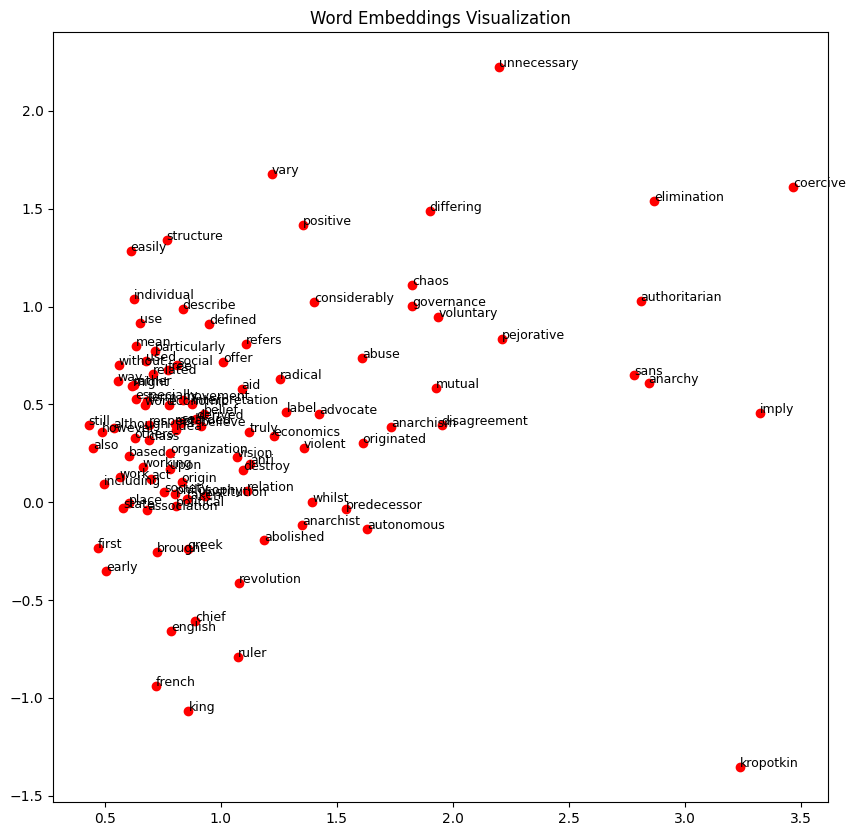

In [ ]:
# Extract embeddings
embeddings = in_embeddings.weight.data.cpu().numpy()

# Visualization
svd = TruncatedSVD(n_components=2)
embeddings_2d = svd.fit_transform(embeddings)
plt.figure(figsize=(10, 10))
for i in range(100):
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], color='red')
    plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], index_dict[i], fontsize=9)
plt.title("Word Embeddings Visualization")
plt.show()


In [ ]:
# similarity analysis
def get_embedding(word):
    idx = vocab_dict.get(word, None)
    return embeddings[idx] if idx is not None else None

def find_closest(embedding, top_n=5):
    norm_embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
    embedding_norm = embedding / np.linalg.norm(embedding)
    cosine_similarities = np.dot(norm_embeddings, embedding_norm)
    best = np.argsort(-cosine_similarities)[:top_n]
    return [(index_dict[idx], cosine_similarities[idx]) for idx in best]

In [ ]:
# king - man + woman ≈ queen
words_example = ["king", "man", "woman"]
embeddings_example = [get_embedding(w) for w in words_example]
if all(x is not None for x in embeddings_example):
    new_embedding = embeddings_example[0] - embeddings_example[1] + embeddings_example[2]
    print("Closest words to (king - man + woman):")
    print(find_closest(new_embedding, top_n=10))

Closest words to (king - man + woman):
[('king', np.float32(0.71120095)), ('woman', np.float32(0.52033675)), ('marry', np.float32(0.46830696)), ('eschiva', np.float32(0.46059245)), ('daughter', np.float32(0.44852918)), ('married', np.float32(0.42816848)), ('templar', np.float32(0.42565423)), ('sidon', np.float32(0.42352828)), ('marched', np.float32(0.41753978)), ('wife', np.float32(0.4127772))]


In [ ]:
print(find_closest(get_embedding('man')))

[('man', np.float32(1.0)), ('young', np.float32(0.48773667)), ('love', np.float32(0.47258523)), ('gimme', np.float32(0.4565183)), ('anthropos', np.float32(0.45590144))]


### I have used only top 10 lakh tokens for the training to reduce the time of training.
### window size - a smaller window focuses on immadieate word relation ships while the larger ones capture semantic meaning across a wider context.

### larger embedding dimension capture high semantic and syntactic analysis but requires more data and computational resources.

### more negative samples - better discrimination between context words and noise but very high number of negative samples leads to excess computation time